This notebook generates Figure 2c in the Sei framework manuscript, showing that regulatory sequence-class-level variant effects are predictive of directional GTEx variant gene expression effects. 

In [1]:
from collections import defaultdict
import glob
import os

import numpy as np
import pandas as pd
from scipy.stats import spearmanr
from statsmodels.stats.multitest import multipletests


In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

plt.style.use('seaborn-white')

mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rc('xtick', labelsize=24)
mpl.rc('ytick', labelsize=24)
mpl.rc('axes', titlesize=24)
mpl.rc('legend', fontsize=18)



We downloaded and processed the [GTEx v8 data](https://storage.googleapis.com/gtex_analysis_v8/single_tissue_qtl_data/GTEx_Analysis_v8_eQTL.tar) and [GENCODE transcript .gtf file](https://storage.googleapis.com/gtex_analysis_v8/reference/gencode.v26.GRCh38.genes.gtf) used in the GTEx analyses. Set the data filepaths accordingly:

In [3]:
GTEX_DATA_DIR = './data/GTEx_Analysis_v8_eQTL'
GENCODE_GTF = './data/gencode.v26.GRCh38.genes.gtf'
RESOURCES_DIR = '../resources'
SEI_DIR = './sei_data'
FIGS_DIR = './figures'

In [4]:
SC_NAMES_FILE = os.path.join(RESOURCES_DIR, 'cnames.tsv')
df = pd.read_csv(SC_NAMES_FILE, sep='\t')
df.head()
MAPPING = {}
for row in df.itertuples():
    MAPPING[row.index] = '{0} {1}'.format(row.ID, row.name)

In [5]:
ensg_gene_coordinates = {}
with open(GENCODE_GTF, 'r') as fh:
    for line in fh:
        if '##' in line:
            continue
        cols = line.strip().split('\t')
        coordinates = (cols[0], int(cols[3]), int(cols[4]))
        ensg_id = cols[8].split(';')[0].split(' ')[1][1:-1]
        ensg_gene_coordinates[ensg_id] = coordinates

Collect all eQTLs and their effect sizes (slope) for a tissue +/- `N_FROM_TSS` of any gene. Note these next 3 cells will take a few minutes to run.

In [6]:
N_FROM_TSS = 5000
tissue_variants_near_tss = defaultdict(list)
for fp in glob.glob(os.path.join(GTEX_DATA_DIR, '*variant_gene_pairs.txt.gz')):
    tissue = os.path.basename(fp).split('.')[0]
    print('Processing {0}'.format(tissue))
    df = pd.read_csv(fp, sep='\t')
    for v, g in zip(df['variant_id'].tolist(), df['gene_id'].tolist()):
        gchrom, gpos, _ = ensg_gene_coordinates[g]
        cols = v.split('_')
        chrom = cols[0]
        pos = int(cols[1])
        if pos >= gpos - N_FROM_TSS and pos <= gpos + N_FROM_TSS:
            record = {'chrom': chrom,
                      'pos': pos,
                      'ref': cols[2],
                      'alt': cols[3],
                      'gene': g}
            tissue_variants_near_tss[tissue].append(record)

Processing Brain_Cortex
Processing Uterus
Processing Brain_Hippocampus
Processing Skin_Sun_Exposed_Lower_leg
Processing Brain_Amygdala
Processing Esophagus_Gastroesophageal_Junction
Processing Brain_Hypothalamus
Processing Adipose_Visceral_Omentum
Processing Pituitary
Processing Brain_Caudate_basal_ganglia
Processing Breast_Mammary_Tissue
Processing Minor_Salivary_Gland
Processing Brain_Spinal_cord_cervical_c-1
Processing Liver
Processing Brain_Cerebellar_Hemisphere
Processing Colon_Sigmoid
Processing Small_Intestine_Terminal_Ileum
Processing Stomach
Processing Brain_Frontal_Cortex_BA9
Processing Adrenal_Gland
Processing Artery_Coronary
Processing Colon_Transverse
Processing Artery_Aorta
Processing Brain_Substantia_nigra
Processing Thyroid
Processing Cells_EBV-transformed_lymphocytes
Processing Brain_Nucleus_accumbens_basal_ganglia
Processing Adipose_Subcutaneous
Processing Skin_Not_Sun_Exposed_Suprapubic
Processing Cells_Cultured_fibroblasts
Processing Pancreas
Processing Muscle_Skele

In [7]:
fn_vid_slopes = defaultdict(dict)
for fp in glob.glob(os.path.join(GTEX_DATA_DIR, '*variant_gene_pairs.txt.gz')):
    df = pd.read_csv(fp, sep='\t')
    fn = os.path.basename(fp).split('.')[0]
    for r in df.itertuples():
        vcols = r.variant_id.split('_')
        vid = (vcols[0], int(vcols[1]), vcols[2], vcols[3])
        fn_vid_slopes[fn][vid] = r.slope

In [8]:
variants = set()
for fp in glob.glob(os.path.join(GTEX_DATA_DIR, '*variant_gene_pairs.txt.gz')):
    fn = os.path.basename(fp).split('.')[0]
    df = pd.read_csv(fp, sep='\t')
    variants_set = set(df['variant_id'].tolist())
    variants |= variants_set

variant_records = []
for v in variants:
    cols = v.split('_')
    record = {'chrom': cols[0],
              'pos': int(cols[1]),
              'ref': cols[2], 'alt': cols[3]}
    variant_records.append(record)

variants_df = pd.DataFrame.from_records(variant_records)
variants_df.sort_values(['chrom', 'pos'], inplace=True)
variants_df = variants_df[['chrom', 'pos', 'ref', 'alt']]
all_variants = variants_df.to_records()

We have saved the Sei predictions for 1000 Genomes variants (which we use in another analysis). `chrom_start_tags.npy` and `chrom_end_tags.npy` are used just to figure out which files of Sei predictions we query in order to get the eQTL (variant) effect predictions for the GTEx tissues.

In [9]:
START_TAGS = np.load(os.path.join(
    SEI_DIR, 'chrom_start_tags.npy'), allow_pickle=True).item()
END_TAGS = np.load(os.path.join(
    SEI_DIR, 'chrom_end_tags.npy'), allow_pickle=True).item()
tags = set(END_TAGS.values()) | set(START_TAGS.values())
tags = sorted(tags)

In [10]:
def populate_dict(lt):
    file_tag_dict = defaultdict(list)
    not_matched = []
    for row in lt:
        chrom = row[1]
        pos = row[2]
        ref = row[3]
        alt = row[4]
        in_s_tags = []
        in_e_tags = []
        for (schrom, spos), tag in START_TAGS.items():
            if schrom == chrom and pos >= spos:
                in_s_tags.append(tag)
        for (echrom, epos), tag in END_TAGS.items():
            if echrom == chrom and pos <= epos:
                in_e_tags.append(tag)
        match_tag = list(set(in_s_tags) & set(in_e_tags))
        if len(match_tag) != 1:
            not_matched.append(row)
        else:
            file_tag_dict[match_tag[0]].append((chrom, pos, ref, alt))
    return file_tag_dict, not_matched

gtex_tag_1000G, gtex_nm = populate_dict(all_variants)

(There are <0.02% variants that weren't mapped from the existing set of predictions)

In [11]:
N_eQTLs = 0
for lt in gtex_tag_1000G.values():
    N_eQTLs += len(lt)
len(gtex_nm), N_eQTLs

(743, 4631714)

Get the sequence class variant effect scores for the GTEx eQTLs. This will take a few minutes to run.

In [12]:
def get_scores(data_dir, score="diffs"):
    all_scores = []
    all_dfs = []
    for tag in tags:
        print(tag)
        lt = gtex_tag_1000G[tag]
        scores = np.load(os.path.join(
            data_dir, '1000Genomes.{0}.{1}.npy'.format(tag, score)))
        rows_fp = os.path.join(
            SEI_DIR, '1000G_vcfs', '1000Genomes.{0}.vcf'.format(tag))
        df = pd.read_csv(rows_fp, sep='\t', header=None)
        df.columns = ['chrom', 'pos', 'id', 'ref', 'alt']
        df['chrom'] = 'chr' + df['chrom'].astype(str)

        index = list(df.index)  # this means the index will match the row labels file
        df.set_index(['chrom', 'pos', 'ref', 'alt'], inplace=True)
        df['ix'] = index
        subset_df = df.loc[df.index.intersection(lt)]
        subset_df.sort_values(['chrom', 'pos'], inplace=True)
        subset_ixs = [int(ix) for ix in subset_df['ix']]
        score_subset = scores[subset_ixs]
        all_scores.append(score_subset)
        all_dfs.append(subset_df)
    return np.vstack(all_scores), pd.concat(all_dfs)

In [13]:
SCORE_DIR = os.path.join(SEI_DIR, "1000G_EUR_seqclass_scores")
seqclass_diffs, seqclass_diff_df = get_scores(SCORE_DIR, score='diffs')

aa
ab
ac
ad
ae
af
ag
ah
ai
aj
ak
al
am
an


/mnt/home/kchen/anaconda3/envs/sei-manu/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3337: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [14]:
seqclass_diff_df['row_ix'] = list(range(len(seqclass_diff_df)))

In [15]:
seqclass_diff_df.head()

id   ix  row_ix
chrom pos   ref alt                
chr1  54490 G   A    .  171       0
      58814 G   A    .  254       1
      60249 C   T    .  266       2
      60351 A   G    .  268       3
      61920 G   A    .  299       4

Compute the Spearman's rank correlation for the top 15,000 sequence class variant effect scores and the corresponding eQTL effect sizes (slope). 

In [16]:
def get_diff_predictions(diff_data, diff_df):
    all_diff_predictions = []
    all_slopes = []
    all_variants = []
    for fn, records in tissue_variants_near_tss.items():
        variants = [(r['chrom'], r['pos'], r['ref'], r['alt']) for r in records]
        subset_df = diff_df.loc[diff_df.index.intersection(variants)]
        subset_data = diff_data[subset_df['row_ix'].tolist()]
        all_diff_predictions.append(subset_data)
        
        subset_variants = subset_df.index.tolist()
        for v in subset_variants:
            all_slopes.append(fn_vid_slopes[fn][v])
            all_variants.append('_'.join([str(x) for x in v]))
    
    return np.vstack(all_diff_predictions), np.array(all_slopes), np.array(all_variants)

In [17]:
def get_seqclass_slope_correlations_no_dups(input_diff_data, 
                                            input_slopes, 
                                            input_variants, 
                                            use_N=15000):
    corrs = defaultdict(float)
    pvalues = defaultdict(float)
    sds = defaultdict(float)
    avgs = defaultdict(float)
    clusters = []
    for c in range(40):
        if 'HET' in MAPPING[c] or 'Low' in MAPPING[c]:
            continue
        clusters.append(c)
        top_ixs = np.argsort(-1 * np.abs(input_diff_data[:, c]))
        top_diffs = input_diff_data[top_ixs[:use_N], c]
        top_slopes = input_slopes[top_ixs[:use_N]]
        top_variants = input_variants[top_ixs[:use_N]]
        
        top_avg_slopes = defaultdict(list)
        corresponding_diffs = {}
        for i, v in enumerate(top_variants):
            if v not in corresponding_diffs:
                corresponding_diffs[v] = top_diffs[i]
            top_avg_slopes[v].append(top_slopes[i]) 
        
        top_diffs = [corresponding_diffs[k] for k in top_avg_slopes.keys()]
        top_slopes = [np.average(slopes) for slopes in top_avg_slopes.values()]
        r, p = spearmanr(top_diffs, top_slopes)
        corrs[c] = r
        pvalues[c] = p
        sds[c] = np.std(np.abs(top_diffs))
        avgs[c] = np.average(np.abs(top_diffs))
    
    pvalues = np.array([pvalues[c] for c in clusters])
    corrs = np.array([corrs[c] for c in clusters])
    sds = np.array([sds[c] for c in clusters])
    avgs = np.array([avgs[c] for c in clusters])
    
    reject, pvs_corrected, _, _ = multipletests(
        pvalues, alpha=0.01, method='fdr_bh', is_sorted=False)
    for i, (corr, sd, pv) in enumerate(zip(corrs, sds, pvs_corrected)):
        print(i, corr, sd, -np.log10(pv), pv < 0.05)
    return np.array(clusters), corrs, pvs_corrected, sds, avgs

In [18]:
sc_near_tss, sc_slopes, sc_variants = get_diff_predictions(seqclass_diffs, seqclass_diff_df)

In [19]:
seqclasses, sc_corrs, sc_pvs, sc_sds, sc_avgs = get_seqclass_slope_correlations_no_dups(
    sc_near_tss, sc_slopes, sc_variants, use_N=15000)

0 -0.08019669733068138 0.3177059981571498 3.080948937192893 True
1 -0.022534647221306773 0.6799108812690963 0.3990098431213617 False
2 -0.018272035162478974 0.5994728476201411 0.3277784015779298 False
3 0.06975528962882653 0.7304853341435054 2.425431261438215 True
4 0.06894433460327667 0.49686390204839026 2.3543852904764577 True
5 0.08402328518151321 0.46644264269310476 3.2634106988792193 True
6 0.1066368824783435 1.6844704180612542 4.7202814639201405 True
7 0.04124706387016578 0.3849664176307059 1.0998618133418203 False
8 0.09550458920805814 0.8229149893572875 3.7585925152766935 True
9 0.10265198697090869 1.5151010551691058 4.616618194423539 True
10 0.07616886277563079 0.6723003428900357 3.0190964520761026 True
11 -0.006032736773818042 0.350523084062826 0.0988811937943088 False
12 0.11632536127818832 0.8540903880893299 5.228363931956797 True
13 0.10630799604307775 0.72928325405817 4.7202814639201405 True
14 0.06130307554154014 0.9173979578848382 2.0301329750536263 True
15 -0.085854232

Visualize the results

In [20]:
def num_split(s):
    head = s.rstrip('0123456789')
    tail = s[len(head):]
    return head, tail

class_categories = defaultdict(list)
for c, label in MAPPING.items():
    classname = label.split(' ')[0]
    classtype, _ = num_split(classname)
    class_categories[classtype].append(c)
class_categories

defaultdict(list,
            {'E': [12, 16, 36, 38, 5, 30, 7, 26, 6, 9, 17, 13],
             'CTCF': [27],
             'P': [25],
             'PC': [34, 0, 15, 20],
             'HET': [11, 23, 29, 32, 35, 39],
             'TN': [2, 3, 21, 28],
             'TF': [37, 19, 14, 31, 10],
             'L': [8, 18, 22, 24, 33, 1, 4]})

In [21]:
color_map = {
    'E': "#984ef3",
    'CTCF': "#fdb462",
    'P': "#ef3b2c",
    'PC': "#8abad4",
    'HET': "#662506",
    'TN': "#fb9a99",
    'TF': "#386cb0",
    'L': "#C0C0C0"
}

In [22]:
def plot_corr_stddev_volcano(clusters, corrs, fdrs, avg_diffs, savefile):
    corrs = corrs
    corr_sorted_ixs = np.argsort(-1 * corrs)
    corrs = corrs[corr_sorted_ixs]
    fdrs = fdrs[corr_sorted_ixs]
    clusters = clusters[corr_sorted_ixs]
    avg_diffs = avg_diffs[corr_sorted_ixs]
    
    pass_fdrs = fdrs[fdrs < 0.05]
    pass_corrs = corrs[fdrs < 0.05]
    rem_fdrs = fdrs[fdrs >= 0.05]
    rem_corrs = corrs[fdrs >= 0.05]
    
    fig = plt.figure(figsize=(13, 10))
    ax = fig.add_subplot(1, 1, 1)
    
    for label, classes in class_categories.items():
        inter = np.in1d(clusters[fdrs < 0.05], classes)
        ax.scatter(pass_corrs[inter], -np.log10(pass_fdrs)[inter],
                   marker='o',
                   s=100 + 15*-np.log10(pass_fdrs[inter]),
                   alpha=0.7,
                   color=color_map[label]) 
        for c, x, y in zip(clusters[fdrs < 0.05][inter],
                           pass_corrs[inter],
                           -np.log10(pass_fdrs)[inter]):
            print(MAPPING[c], x, y)
            ax.annotate(MAPPING[c], (x, y), fontsize=24)
    
    ax.scatter(rem_corrs, -np.log10(rem_fdrs),
               marker='X', s=80, color='lightgray',
               label='NS (fdr > 0.05)')
    for c, x, y in zip(clusters[fdrs >= 0.05],
                        rem_corrs,
                        -np.log10(rem_fdrs)):
        ax.annotate(MAPPING[c].split(' ')[0], (x, y), fontsize=22, c='#C0C0C0')
        
    ax.spines['left'].set_position('center')
    
    ax.legend(frameon=True, loc='lower right')
    
    ax.set_xlabel("Spearman's correlation", fontsize=20)
    ax.set_ylabel('-log10(p-value)', fontsize=20)
    s, e = -1 * np.max(np.abs(corrs)), np.max(np.abs(corrs))
    s += 0.01
    e += 0.01
    print(s, e)
    ax.set_xlim([s, e])
    plt.plot([s, e], [-np.log10(0.05), -np.log10(0.05)], linewidth=0.75, linestyle='--', c='gray')
    plt.tight_layout()
    plt.savefig(savefile, dpi=300)

E7 Monocyte / Macrophage 0.11632536127818832 5.228363931956797
E12 Erythroblast-like 0.11545319136999391 5.228363931956797
E4 Multi-tissue 0.1066368824783435 4.7202814639201405
E8 Weak multi-tissue 0.10630799604307775 4.7202814639201405
E11 T-cell 0.10345656489616137 4.616618194423539
E6 Weak epithelial 0.10265198697090869 4.616618194423539
E5 B-cell-like 0.09550458920805814 3.7585925152766935
E10 Brain 0.0934396333170497 4.09607117165388
E3 Brain / Melanocyte 0.08402328518151321 3.2634106988792193
E9 Liver / Intestine 0.08323523055688424 3.1715535522129206
E1 Stem cell 0.06975528962882653 2.425431261438215
E2 Multi-tissue 0.06894433460327667 2.3543852904764577
CTCF CTCF-Cohesin 0.06606386666091946 2.1970130849779776
P Promoter 0.13763803576821773 6.741199578947915
PC1 Polycomb / Heterochromatin -0.08019669733068138 3.080948937192893
PC3 Polycomb -0.08585423249153407 3.6306805695209854
PC4 Polycomb / Bivalent stem cell Enh -0.10098124899059627 4.616618194423539
TF5 AR 0.102464424348171

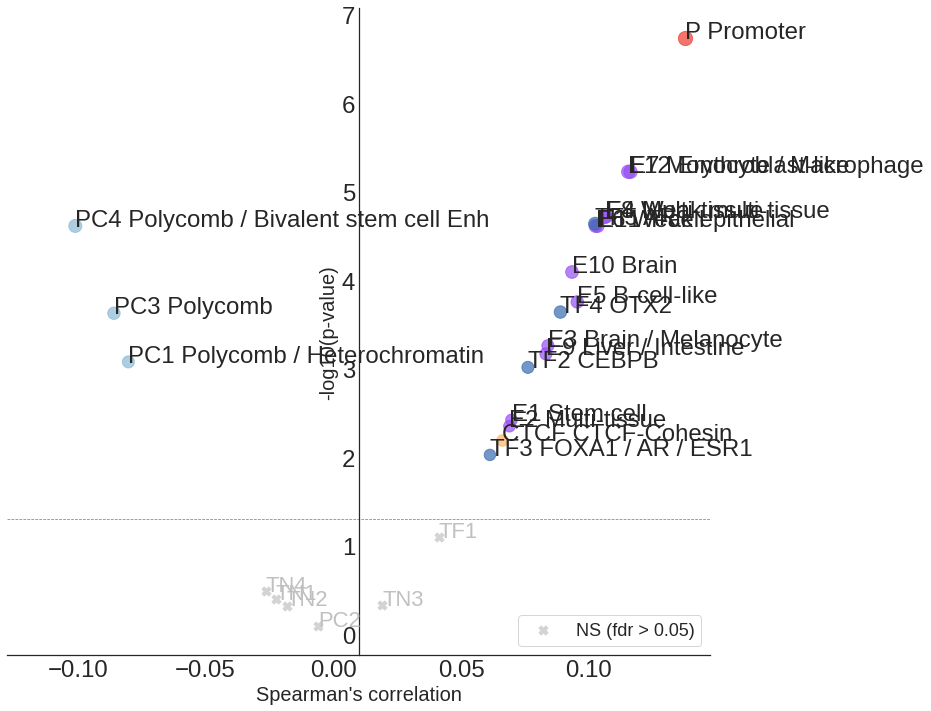

In [23]:
plot_corr_stddev_volcano(seqclasses, sc_corrs, sc_pvs, sc_avgs, 
    os.path.join(FIGS_DIR, 'threshold.gtex_slope.corr_pvalues.seqclass_variant_effects.pdf'))